In [1]:
import os
import librosa
import numpy as np
import random
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import pyfftw
import scipy
import ssqueezepy
%matplotlib notebook

ssqueezepy.FFT_GLOBAL.verbose = 0

def load_data(data_folder, folders_to_load=None):
    female_data = {}
    male_data = {}
    if folders_to_load is None:
        folders_to_load = set(os.listdir(data_folder))
    
    for gender_folder in os.listdir(data_folder):
        if gender_folder in folders_to_load:
            gender_path = os.path.join(data_folder, gender_folder)
        else:
            continue
        
        if os.path.isdir(gender_path):
            gender_data = []
            for file in os.listdir(gender_path):
                file_path = os.path.join(gender_path, file)
                        
                # Load audio file using librosa
                y, sr = librosa.load(file_path, sr=None)
                # Append the audio data to the gender_data list
                gender_data.append((y, sr))
            
            # Use gender_folder as the key in the appropriate dictionary
            if "female" in gender_folder.lower():
                female_data[gender_folder] = gender_data
            elif "male" in gender_folder.lower():
                male_data[gender_folder] = gender_data
                
    return female_data, male_data

# Define the path to the data folder
data_folder = "data"
train_data = "train"
data_folder_path = os.path.join(os.pardir, data_folder, train_data)

# Load data
folders_to_load = set(["female1", "male1"])
female_data, male_data = load_data(data_folder_path, folders_to_load)

# Define the path to the data folder
data_folder = "data"
test_data = "test"
data_folder_path = os.path.join(os.pardir, data_folder, test_data)
# Load data
folders_to_load = set(["female", "male"])
female_data_test, male_data_test = load_data(data_folder_path, folders_to_load)

female_test = female_data_test['female']
male_test = male_data_test['male']

In [2]:
import scipy

female1_data=female_data["female1"]
male1_data=male_data["male1"]
num_to_sample = 3  

def downsample_data(data, downsample_factor=10):
    for idx, sample in enumerate(data):
        fs = sample[1]
        audio = sample[0]
        ds = scipy.signal.decimate(audio, q=downsample_factor//2)
        data[idx] = (scipy.signal.decimate(ds, q=downsample_factor//2), 
                     fs/(downsample_factor//2 + downsample_factor//2))
    return data

np.random.seed(42)

female_sample = downsample_data(random.sample(female1_data, num_to_sample))
male_sample = downsample_data(random.sample(female1_data, num_to_sample))

import matplotlib
def plot_data_specgram(data,NFFT=256, window=matplotlib.mlab.window_hanning, noverlap=128, title=''):
        
    num_examples = len(data)
    
    fig, axes = plt.subplots(num_examples, 1, figsize=(10, 10*num_examples))
    axes = axes.ravel()
    fig.suptitle(title)
    
    for i in range(num_examples):
        
        k = i%2 #if even it's a cat, if odd it's a dog 
        key = keys[k][i//2] # 0 0, 1 1, 2 2, ...
        fs = dictionaries[k][key][1] # key: (y, fs)
        y = dictionaries[k][key][0]
        
        #f, Pyy = scipy.signal.welch(y, fs, nperseg=256)
        axes[i].specgram(x=y, Fs=fs, NFFT=NFFT, window=window, noverlap=noverlap, pad_to=2048)
        axes[i].grid('on')
        axes[i].set_xlabel('$t$ [s]')
        axes[i].set_ylabel('$f$ [Hz]')
        axes[i].set_title(key+ f' fs = {fs} [Hz]' + f" dt = {(NFFT-noverlap)*1000/fs} ms df = {fs/NFFT} Hz ")
        
    plt.tight_layout()
    plt.show()



<IPython.core.display.Javascript object>


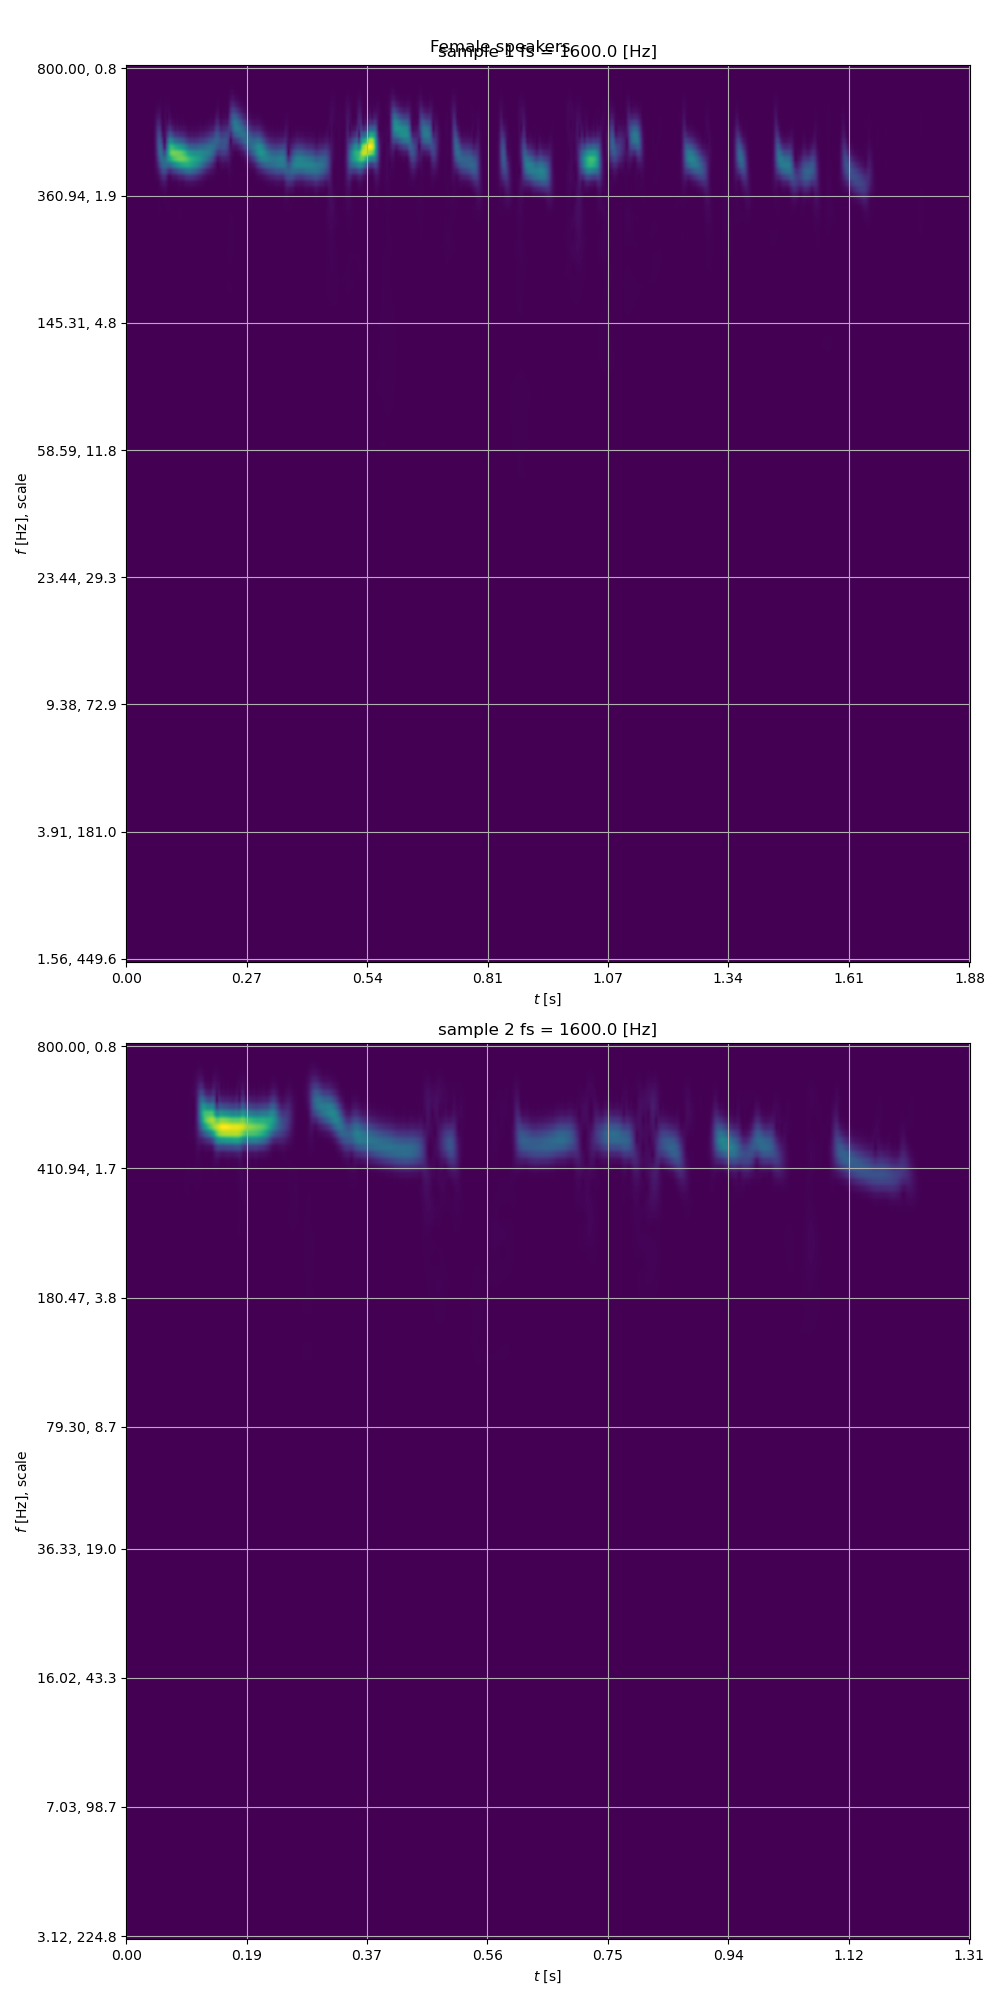

<IPython.core.display.Javascript object>


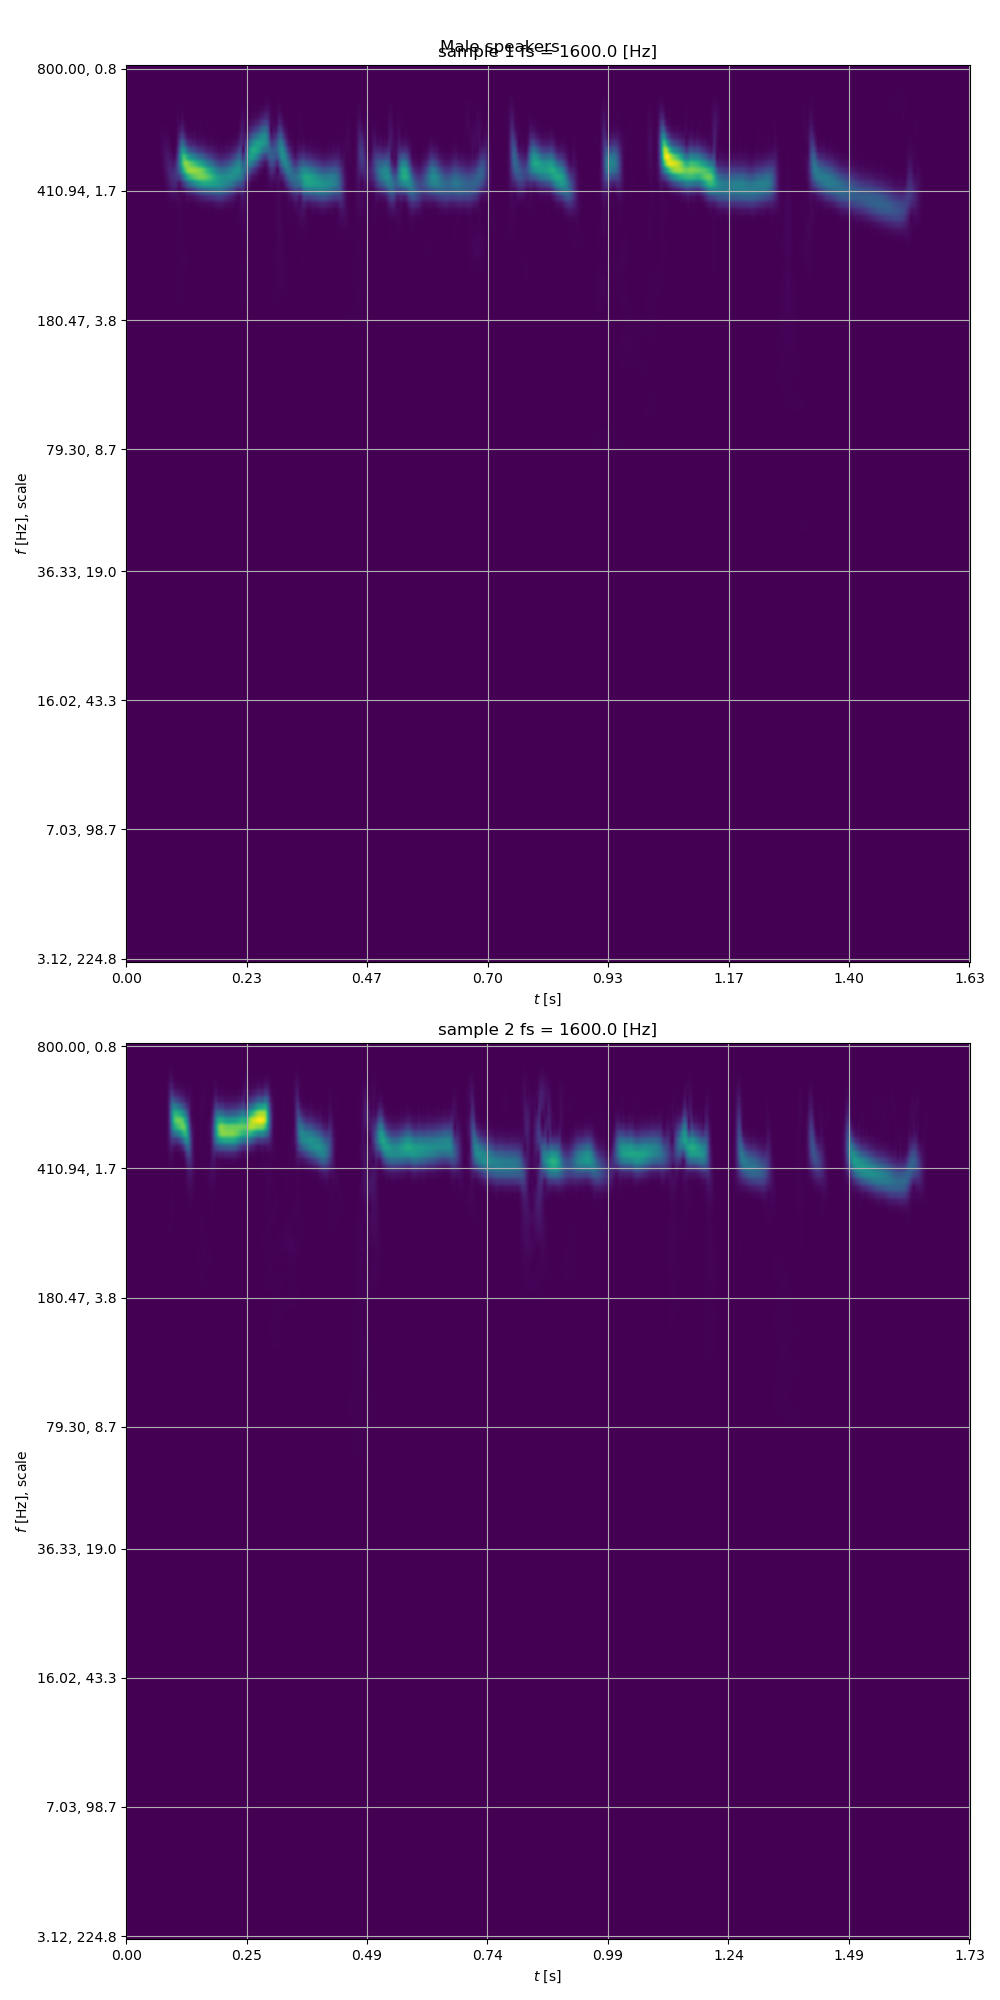

In [3]:


import ssqueezepy
import matplotlib.pyplot as plt


def fmt(ticks):
    if all(isinstance(h, str) for h in ticks):
        return "%s"
    return ("%.d" if all(float(h).is_integer() for h in ticks) else
                "%.2f")

def add_x_y_ticks(freqs_cwt, scales, t, ax):    
    # Adding logarihmic labels to y-axis:
    idxs = np.linspace(0, len(freqs_cwt) - 1, 8).astype('int32')
    yt = [fmt(freqs_cwt) % h for h in np.asarray(freqs_cwt)[idxs]] 
    for idx, freq_idx in enumerate(idxs):
        yt[idx] += ', ' + str(np.round(scales[freq_idx], 1))
        
    ax.set_yticks(idxs)
    ax.set_yticklabels(yt)
    
    idxs = np.linspace(0, len(t) - 1, 8).astype('int32')
    xt = [fmt(t) % h for h in np.asarray(t)[idxs]]
    ax.set_xticks(idxs)
    ax.set_xticklabels(xt)
    
    return ax


def plot_data_cwt(data, wavelet='gmw',  nv=16, title=''):
    num_examples = len(data)
   
    wavelet = ssqueezepy.Wavelet(wavelet=wavelet)
   
    fig, axes = plt.subplots(num_examples, 1, figsize=(10, 10*num_examples))
    axes = axes.ravel()
    fig.suptitle(title)
    
    for i in range(num_examples):
        
        fs = data[i][1] # data[i]: (y, fs)
        y = data[i][0]
        
        t = np.arange(len(y))/fs
        #Tx, _, ssq_freqs, scales, *_ = ssqueezepy.ssq_cwt(y, wavelet, nv=nv, fs=fs)
        Tx, scales = ssqueezepy.cwt(y, wavelet,nv=nv, fs=fs,nan_checks=False, scales='log')
        #print(len(scales))
        freqs_cwt = ssqueezepy.experimental.scale_to_freq(scales, wavelet, len(y), fs=fs)
        
        axes[i].imshow(np.abs(Tx),  aspect='auto')
        add_x_y_ticks(freqs_cwt, scales, t, axes[i])
        axes[i].grid('on')
        axes[i].set_xlabel('$t$ [s]')
        axes[i].set_ylabel('$f$ [Hz], scale')
        axes[i].set_title(f'sample {i+1}'+ f' fs = {fs} [Hz]')
        
    plt.tight_layout()
    plt.show()
    
plot_data_cwt(female_sample[0:2], title='Female speakers')
plot_data_cwt(male_sample[0:2], title='Male speakers')

In [4]:
import ssqueezepy
import numpy as np
import scipy

def extract_cwt_features(audio_data, fs, window_size_samples, overlap_samples, window_fcn=np.ones,
                        centering=True, wavelet = ssqueezepy.Wavelet(wavelet='gmw')):
    #wavelet = ssqueezepy.Wavelet(wavelet='gmw')
    
    if overlap_samples >= window_size_samples:
        overlap_samples -= 1
        print('Warning: overlap_samples must be less than window_size_samples')
        

    window = window_fcn(window_size_samples)
        
    # Calculate featruees
    feature1, feature2, feature3, feature4, feature5, feature6, feature7, feature8, feature9, feature10 =\
    [], [], [], [], [], [], [], [], [], []
    
    start = 0
    end = window_size_samples
    
    while end <= len(audio_data):
        # Extract the current window, data is centered over the window:
        window_data = audio_data[start:end]*window 
        window_data -= centering*np.mean(audio_data[start:end]*window)
        
        # Compute the CWT
        Tx, scales, *_= ssqueezepy.cwt(window_data, wavelet, nv=8, nan_checks=False, patience=1, cache_wavelet=False,
                                      scales=np.arange(1, 32).astype(np.float64))
        
        # Averaging out during the window length
        mTx = np.mean(np.abs(Tx), axis=1)
        mwTx = np.mean(np.abs(Tx.T*scales), axis=0) 
        arg_mTx = np.argsort(mTx)
        arg_mwTx = np.argsort(mwTx)
        
        feature1.append(np.std(mwTx))
        feature2.append(np.std(mTx))
        feature3.append(scales[arg_mTx[-1]])
        feature4.append(scales[arg_mwTx[-1]])
        feature5.append(scales[arg_mTx[-2]])
        feature6.append(np.sum(mwTx))
        feature7.append(np.sum(mTx))
        feature8.append(mTx[arg_mTx[-2]])
        feature9.append(mTx[arg_mTx[-1]])
        feature10.append(mwTx[arg_mwTx[-1]])
        
        # Move to the next window
        start += window_size_samples - overlap_samples
        end += window_size_samples - overlap_samples
    
    # Calculate overall statistics
    feature1 = np.mean(feature1)
    feature2 = np.mean(feature2)
    feature3 = np.mean(feature3)
    feature4 = np.mean(feature4)
    feature5 = np.mean(feature5)
    feature6 = np.mean(feature6)
    feature7 = np.mean(feature7)
    feature8 = np.mean(feature8)
    feature9 = np.mean(feature9)
    feature10  = np.mean(feature10)
    
    
    return  feature1, feature2, feature3, feature4, feature5, feature6, feature7, feature8, feature9, feature10

def extract_features(data, window_size_samples=500, overlap_samples=0, window=np.blackman):
    data_len = len(data)
    features = np.zeros((data_len, 10))
    
    for idx, sample in enumerate(data):
        fs = sample[1]
        audio = sample[0]
        #print(idx)
        
        features[idx, :] = extract_cwt_features(audio, fs, window_size_samples, overlap_samples)
        
    return features

def downsample_data(data, downsample_factor=10):
    for idx, sample in enumerate(data):
        fs = sample[1]
        audio = sample[0]
        ds = scipy.signal.decimate(audio, q=downsample_factor//2)
        data[idx] = (scipy.signal.decimate(ds, q=downsample_factor//2), 
                     fs/(downsample_factor//2 + downsample_factor//2))
    return data

def normalize_data(data):
    for idx, sample in enumerate(data):
        fs = sample[1]
        audio = sample[0]
        norm = np.max(np.abs(audio))
        
        if np.max(np.abs(audio)) == 0:
            norm = 1
            
        data[idx] = (audio/np.max(np.abs(audio)), fs)
    return data

In [5]:
training_data = female1_data + male1_data
labels = [1]*len(female1_data) + [0]*len(male1_data)
labels = np.array(labels).reshape(-1, 1)


test_data = female_test + male_test
test_data = normalize_data(downsample_data(test_data))
test_labels = [1]*len(female_test) + [0]*len(male_test)
test_labels = np.array(test_labels).reshape(-1, 1)

training_data = normalize_data(downsample_data(training_data))

In [6]:
features = extract_features(training_data)
test_features = extract_features(test_data)

In [7]:
def train_test_split(x, y, test_ratio):
    Nx = len(x)
    Ntest = int(Nx*test_ratio)
    
    indices = np.random.permutation(x.shape[0])
    training_idx, test_idx = indices[:Nx-Ntest], indices[Nx-Ntest:]
    x_train, x_test = x[training_idx,:], x[test_idx,:]

    y_train, y_test = y[training_idx,:], y[test_idx,:]
    
    return x_train, x_test, y_train, y_test


def standardize(x_train, x_test):
    mean = np.mean(x_train, axis=0)
    std = np.std(x_train, axis=0)
    
    return (x_train-mean)/std, (x_test-mean)/std, mean, std
    

x_train, x_test, y_train, y_test = train_test_split(features, labels, test_ratio=0.2)

x_train_norm, x_test_norm, mean, std = standardize(x_train, x_test)

In [8]:
def GNB_params(x,y):
    sample, feature = x.shape
    k = []
    k_mean = []
    k_cov = []
    
    num_class = len(np.unique(y))
    for i in range(num_class):
        k.append(x[(y == i).squeeze(), :])
    
    for i in range(num_class):
        k_mean.append(np.mean(k[i], axis = 0).reshape(-1, 1))
        
    for i in range(num_class):
        sigmas =  np.std(k[i], axis=0, ddof=0)**2
        k_cov.append(np.diag(sigmas))
    
    phi = np.zeros(num_class)
    for idx in range(num_class):
        phi[idx] = np.sum(y == idx)/len(y)
    
    return (np.array(k, dtype=object), np.array(k_mean, dtype=object), np.array(k_cov, dtype=object), phi)

k, k_mean, k_cov, phi = GNB_params(x_train_norm, y_train)
print(k_mean.shape, k_cov.shape)
print('mat. ocekivanja: \n', k_mean)
print('kovarijaciona matrice: \n', k_cov)
print('apriorne verovatnoce pojave klasa: \n', phi)

(2, 10, 1) (2, 10, 10)
mat. ocekivanja: 
 [[[0.8828244109898339]
  [0.911383604600777]
  [0.7607830724687975]
  [-0.8842244996662157]
  [-0.0688691969834659]
  [0.6453290913091576]
  [0.9133947991354902]
  [0.9141866258848785]
  [0.890418683249011]
  [0.8901829186656093]]

 [[-0.8750633172668475]
  [-0.9033714410438471]
  [-0.7540948696339057]
  [0.8764510974713446]
  [0.06826375349350032]
  [-0.6396558685284177]
  [-0.9053649547474866]
  [-0.9061498203825951]
  [-0.8825908266929757]
  [-0.8823571347652526]]]
kovarijaciona matrice: 
 [[[0.39848290637300415 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0]
  [0.0 0.32028957009777 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0]
  [0.0 0.0 0.4393297759617531 0.0 0.0 0.0 0.0 0.0 0.0 0.0]
  [0.0 0.0 0.0 0.0247664359081766 0.0 0.0 0.0 0.0 0.0 0.0]
  [0.0 0.0 0.0 0.0 0.6111862261934151 0.0 0.0 0.0 0.0 0.0]
  [0.0 0.0 0.0 0.0 0.0 0.7540203484360745 0.0 0.0 0.0 0.0]
  [0.0 0.0 0.0 0.0 0.0 0.0 0.27930495662557564 0.0 0.0 0.0]
  [0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.33818811303985

In [9]:
import itertools
def predict(x, k_mean, k_cov, phi):
    h = np.zeros((x.shape[0], k_mean.shape[0]))
    for idx in range(x.shape[0]):
        x_row = x[idx, :].reshape(-1, 1)
        h[idx, :] = (-0.5*(x_row-k_mean).transpose((0, 2, 1))@np.linalg.inv(k_cov.astype(float))@(x_row-k_mean)).squeeze()
        
    
    
    all_combos = list(itertools.combinations(list(range(k_mean.shape[0])), 2))
    y = np.zeros((x.shape[0], len(all_combos)))
   
    for k in range(x.shape[0]):
        for idx, val in enumerate(all_combos):
            i = val[0]
            j = val[1]
            y[k, idx] = (h[k, i] - h[k, j]>=-np.log(phi[i]/phi[j]))
            y[k, idx] = y[k, idx]*i + (1-y[k, idx])*j
            
    y_pred = np.median(y, axis = 1)
    return y_pred

<IPython.core.display.Javascript object>


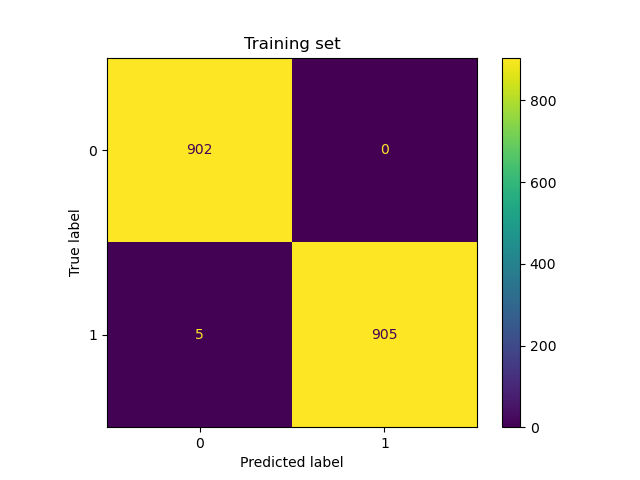

F1:  0.997


<IPython.core.display.Javascript object>


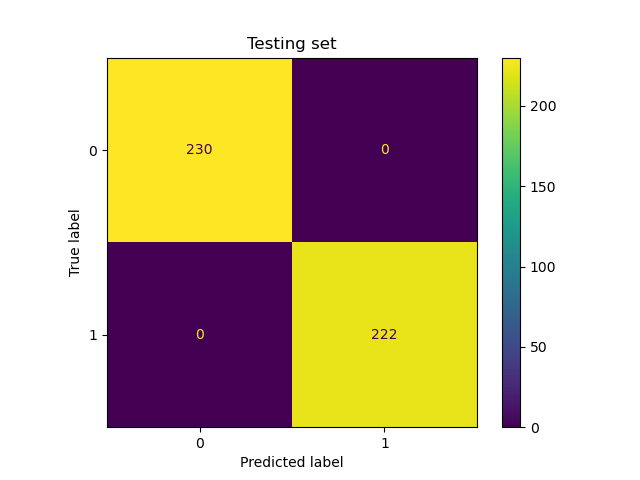

F1:  1.0


<IPython.core.display.Javascript object>


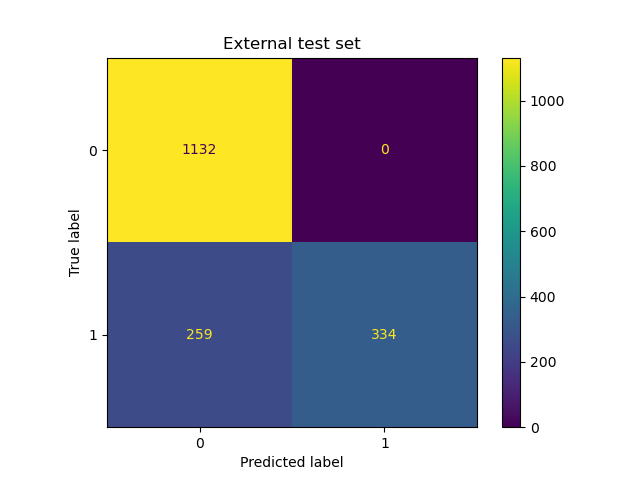

F1:  0.721


In [10]:
y_train_pred = predict(x_train_norm, k_mean, k_cov, phi)

cm = confusion_matrix(y_train, y_train_pred)
#plt.figure()
cm_plot = ConfusionMatrixDisplay(cm)
cm_plot.plot()
plt.title('Training set')

tn, fp, fn, tp = cm.ravel()
f1 = tp/(tp + 0.5*(fp+fn))

plt.show()

print('F1: ', np.round(f1, 3))

y_test_pred = predict(x_test_norm, k_mean, k_cov, phi)

cm = confusion_matrix(y_test, y_test_pred)
#plt.figure()
cm_plot = ConfusionMatrixDisplay(cm)
cm_plot.plot()
plt.title('Testing set')

tn, fp, fn, tp = cm.ravel()
f1 = tp/(tp + 0.5*(fp+fn))

plt.show()

print('F1: ', np.round(f1, 3))


y_ext_test_pred = predict((test_features-mean)/std, k_mean, k_cov, phi)

cm = confusion_matrix(test_labels, y_ext_test_pred)
#plt.figure()
cm_plot = ConfusionMatrixDisplay(cm)
cm_plot.plot()
plt.title('External test set')

tn, fp, fn, tp = cm.ravel()
f1 = tp/(tp + 0.5*(fp+fn))

plt.show()

print('F1: ', np.round(f1, 3))


<IPython.core.display.Javascript object>


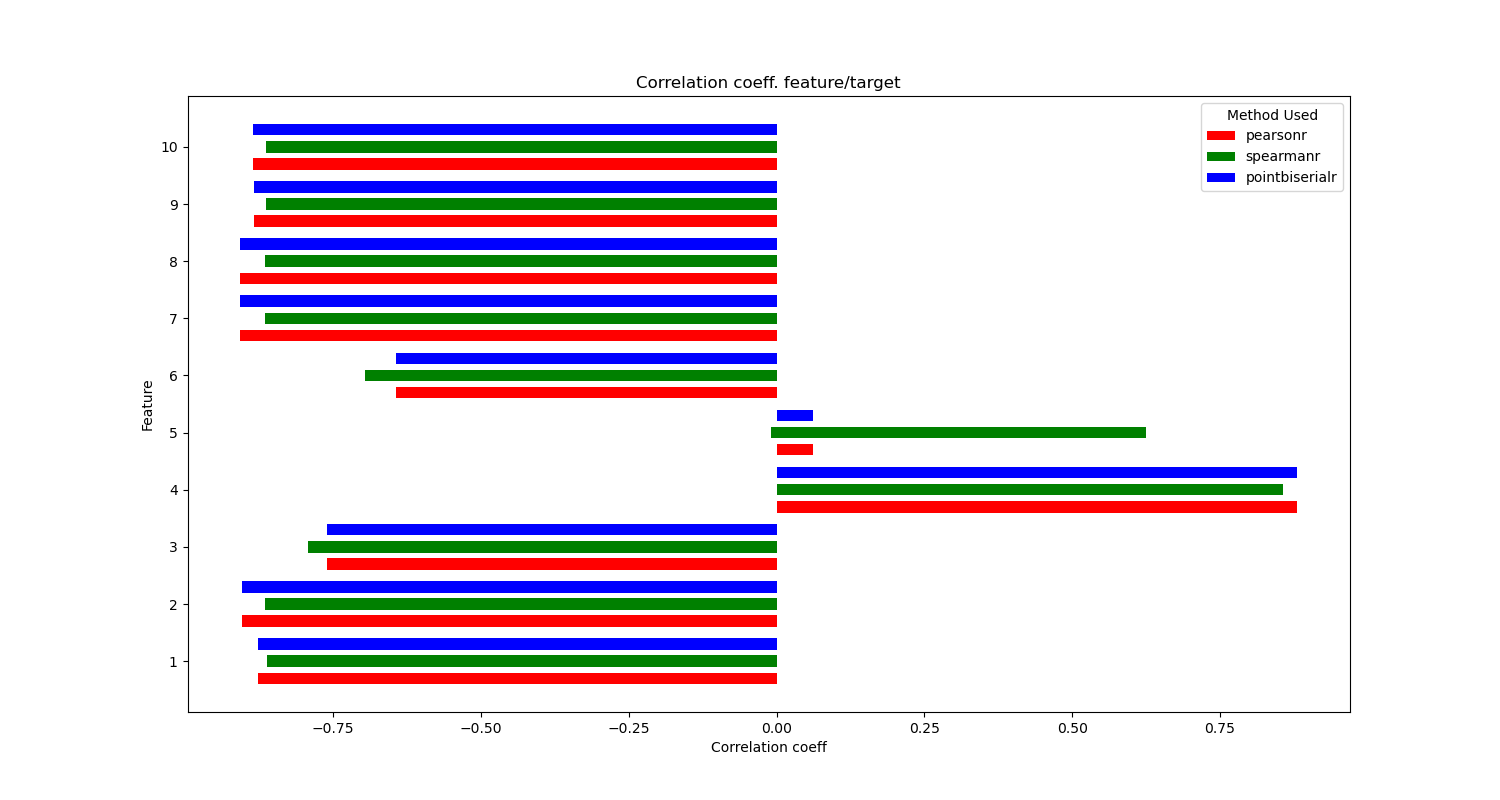

In [11]:
import scipy as scipy

def correlation_feature_target(x, y, correlation_fcn):

    correlation = []
    for target_idx in range(y.shape[1]):
        for feature_idx in range(x.shape[1]):
            name = f"feature_{feature_idx}...target_{target_idx}"
            correlation += [(feature_idx, 
                             correlation_fcn(y[:, target_idx],
                                             x[:, feature_idx]))]
    
    return correlation

correlation_fcns = [scipy.stats.pearsonr, scipy.stats.spearmanr, scipy.stats.pointbiserialr]

corr = []
for val in correlation_fcns:
    corr += [correlation_feature_target(features, labels, val)]
    
import numpy as np
import matplotlib.pyplot as plt

method_labels = [f.__name__ for f in correlation_fcns]
feature_indices = [feature_idx for feature_idx, _ in corr[0]]
bar_width, bar_separation = 0.2, 0.1

plt.figure(figsize=(15, 8))

method_colors = ['red', 'green', 'blue']

ticks = []
for feature_idx in feature_indices:
    y_positions = np.arange(len(method_labels)) * (bar_width + bar_separation) + feature_idx
    data = [corr[method_idx][feature_idx][1] for method_idx in range(len(corr))]
    ticks += [y_positions[0]]
    for idx, pos in enumerate(y_positions):
        plt.barh(pos, data[idx], 
                 height=bar_width, 
                 align='center', 
                 label=method_labels[idx], 
                 color=method_colors[idx])

plt.xlabel('Correlation coeff')
plt.ylabel('Feature')
plt.title('Correlation coeff. feature/target')
plt.legend()
plt.yticks(np.array(ticks) + (bar_width + bar_separation) * (len(method_labels) - 1) / 2,
           np.array(feature_indices)+1)
plt.legend(title='Method Used', labels=method_labels, loc='best')
plt.show()

<IPython.core.display.Javascript object>


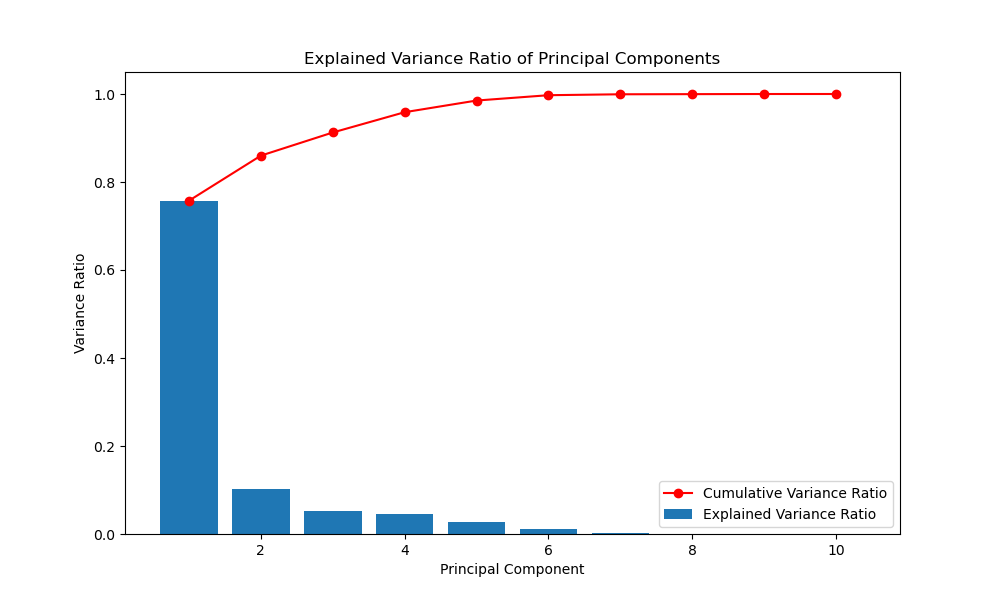

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import svd

def perform_pca(x, n_components=None):
    
    U, S, Vt = svd(x, full_matrices=False)
    
    if n_components is not None:
        U = U[:, :n_components]
        S = np.diag(S[:n_components])
        Vt = Vt[:n_components, :]

    x_pca = U@S

    return Vt.T, x_pca

def plot_explained_variance_ratio(S, n_features=None):
    if n_features is None:
        n_features = min(len(S), 20)

    explained_variance_ratio = (S**2) / np.sum(S**2)
    cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

    plt.figure(figsize=(10, 6))
    plt.bar(range(1, n_features + 1), explained_variance_ratio[:n_features], label='Explained Variance Ratio')
    plt.plot(range(1, n_features + 1), cumulative_variance_ratio[:n_features], marker='o', color='r', label='Cumulative Variance Ratio')
    plt.xlabel('Principal Component')
    plt.ylabel('Variance Ratio')
    plt.title('Explained Variance Ratio of Principal Components')
    plt.legend()
    plt.show()
    
_, S, _ = svd(x_train_norm, full_matrices=False)
plot_explained_variance_ratio(S)


  

In [13]:
V, x_pca_norm = perform_pca(x_train_norm, n_components=4)

In [14]:
k, k_mean, k_cov, phi = GNB_params(x_pca_norm, y_train)
print(k_mean.shape, k_cov.shape)
print('mat. ocekivanja: \n', k_mean)
print('kovarijaciona matrice: \n', k_cov)
print('apriorne verovatnoce pojave klasa: \n', phi)

(2, 4, 1) (2, 4, 4)
mat. ocekivanja: 
 [[[-2.575202576013229]
  [0.017173911720803847]
  [-0.0968967228035686]
  [-0.0050298461421491554]]

 [[2.5525634324878403]
  [-0.017022932277104774]
  [0.09604488348221833]
  [0.004985627714525283]]]
kovarijaciona matrice: 
 [[[1.5905472919473427 0.0 0.0 0.0]
  [0.0 0.6507615371690291 0.0 0.0]
  [0.0 0.0 0.6340981854236278 0.0]
  [0.0 0.0 0.0 0.5583364968908601]]

 [[0.41889251077677775 0.0 0.0 0.0]
  [0.0 1.3927708080509513 0.0 0.0]
  [0.0 0.0 0.4000794332038719 0.0]
  [0.0 0.0 0.0 0.3647789360887239]]]
apriorne verovatnoce pojave klasa: 
 [0.49779249 0.50220751]


<IPython.core.display.Javascript object>


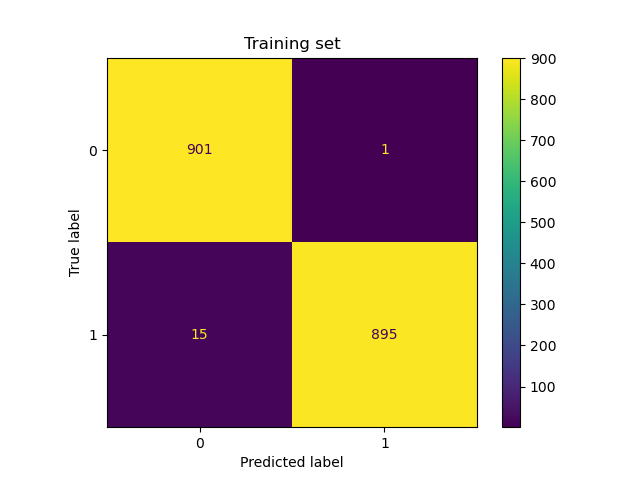

Acc: 0.984
F1:  0.991


<IPython.core.display.Javascript object>


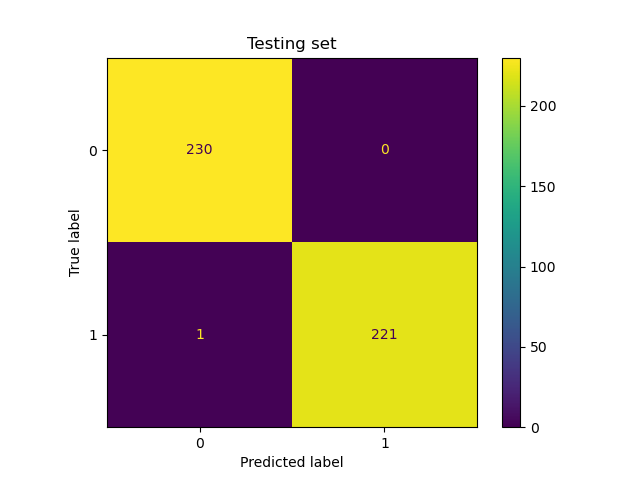

Acc: 0.995
F1:  0.998


<IPython.core.display.Javascript object>


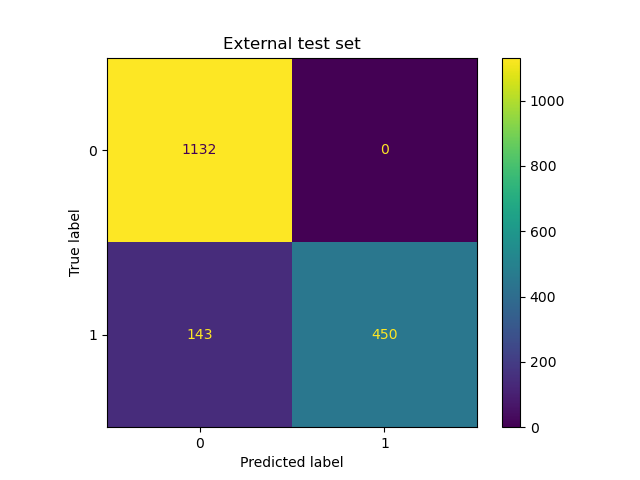

Acc: 0.759
F1:  0.863


In [15]:
y_train_pred = predict(x_pca_norm, k_mean, k_cov, phi)

cm = confusion_matrix(y_train, y_train_pred)
#plt.figure()
cm_plot = ConfusionMatrixDisplay(cm)
cm_plot.plot()
plt.title('Training set')

tn, fp, fn, tp = cm.ravel()
f1 = tp/(tp + 0.5*(fp+fn))

plt.show()

print('Acc:', np.round(tp/(tp + fn), 3))
print('F1: ', np.round(f1, 3))

y_test_pred = predict(x_test_norm@V, k_mean, k_cov, phi)

cm = confusion_matrix(y_test, y_test_pred)
#plt.figure()
cm_plot = ConfusionMatrixDisplay(cm)
cm_plot.plot()
plt.title('Testing set')

tn, fp, fn, tp = cm.ravel()
f1 = tp/(tp + 0.5*(fp+fn))

plt.show()

print('Acc:', np.round(tp/(tp + fn), 3))
print('F1: ', np.round(f1, 3))


y_ext_test_pred = predict(((test_features-mean)/std)@V, k_mean, k_cov, phi)

cm = confusion_matrix(test_labels, y_ext_test_pred)
#plt.figure()
cm_plot = ConfusionMatrixDisplay(cm)
cm_plot.plot()
plt.title('External test set')

tn, fp, fn, tp = cm.ravel()
f1 = tp/(tp + 0.5*(fp+fn))

plt.show()

print('Acc:', np.round(tp/(tp + fn), 3))
print('F1: ', np.round(f1, 3))


Transformed Data Shape: 
 (1812, 1)
Transformation: 
 [[ 0.34241842]
 [ 0.35349559]
 [ 0.29508262]
 [-0.34296147]
 [-0.02671209]
 [ 0.25030184]
 [ 0.35427567]
 [ 0.35458279]
 [ 0.34536399]
 [ 0.34527255]]


<IPython.core.display.Javascript object>


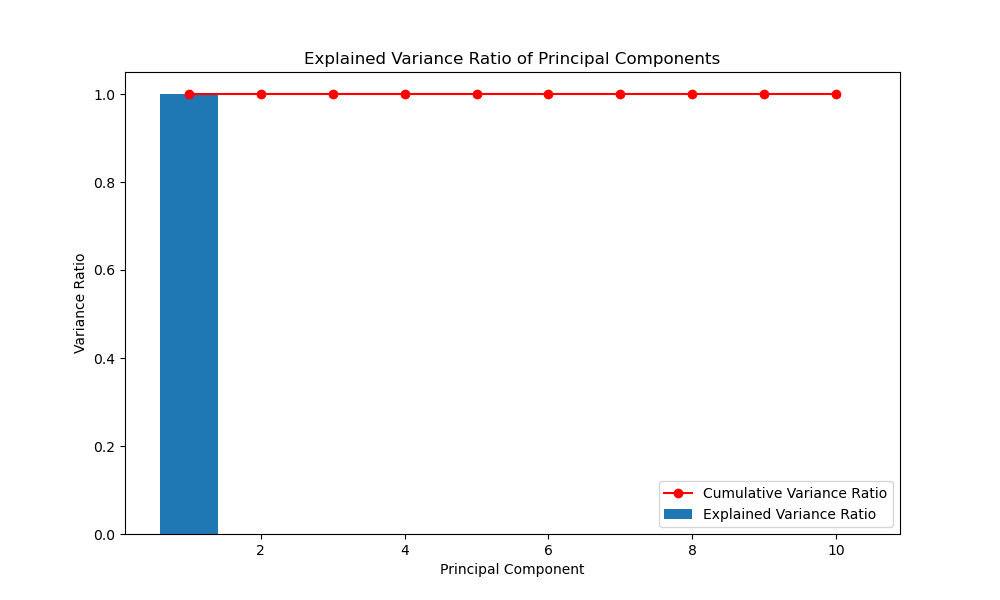

In [16]:
import matplotlib.pyplot as plt
import numpy as np

def plot_explained_variance(lda_model):
    explained_variance_ratio = lda_model[1]
    n_features = len(explained_variance_ratio)
    
    plt.figure(figsize=(10, 6))
    plt.bar(range(1, n_features + 1), explained_variance_ratio, label='Explained Variance Ratio')
    plt.plot(range(1, n_features + 1),np.cumsum(explained_variance_ratio), marker='o', color='r', label='Cumulative Variance Ratio')
    plt.xlabel('Principal Component')
    plt.ylabel('Variance Ratio')
    plt.title('Explained Variance Ratio of Principal Components')
    plt.legend()
    plt.show()

def lda(x, y, n_components=None, mode='SbSw'):
    if n_components is None:
        n_components = 2
        
    # Class means:
    class_means = np.array([np.mean(x[(y == c).squeeze(), :], axis=0) for c in np.unique(y)])

    # Class probabilities:
    class_probs = np.array([np.mean(y == c) for c in np.unique(y)])
    
    # Within-class scatter matrix:
    Sw = sum([np.cov((x[(y == c).squeeze(), :] - class_means[i]).T) * class_probs[i] 
                                      for i, c in enumerate(np.unique(y))])

    
    overall_mean = sum([class_means[i, :]*c for i, c in enumerate(class_probs)])
    
    # Between-class scatter matrix:
    Sb = sum([(class_means[i] - overall_mean).reshape(-1,1)@(class_means[i] - overall_mean).reshape(1,-1) * class_probs[i] 
                                    for i, c in enumerate(np.unique(y))])
    
    Sm = Sw + Sb
    
    if mode=='SbSw':
        Smin = np.linalg.inv(Sw)
        Smax = Sb
    elif mode=='SbSm':
        Smin = np.linalg.inv(Sm)
        Smax = Sb
    elif mode=='SwSm':
        Smin = np.linalg.inv(Sm)
        Smax = Sw
    
    # Solve the generalized eigenvalue problem
    U, S, Vt = svd(Smin@Smax, full_matrices=False)

    # Select the top n_components
    W = Vt[:n_components, :]
    W = W.T
    
    # Project the data onto the new subspace
    x_lda = x@W
    

    return W, x_lda, S


W, x_lda, S = lda(x_train_norm, y_train, n_components=1, mode='SbSm')


# Print the shape of the transformed data
print("Transformed Data Shape: \n", x_lda.shape)

print("Transformation: \n", W)

plot_explained_variance_ratio(S)


In [17]:
k, k_mean, k_cov, phi = GNB_params(x_lda, y_train)
print(k_mean.shape, k_cov.shape)
print('mat. ocekivanja: \n', k_mean)
print('kovarijaciona matrice: \n', k_cov)
print('apriorne verovatnoce pojave klasa: \n', phi)

(2, 1, 1) (2, 1, 1)
mat. ocekivanja: 
 [[[2.5782035941950343]]

 [[-2.555538068092221]]]
kovarijaciona matrice: 
 [[[1.5289710594207682]]

 [[0.4162921879205998]]]
apriorne verovatnoce pojave klasa: 
 [0.49779249 0.50220751]


<IPython.core.display.Javascript object>


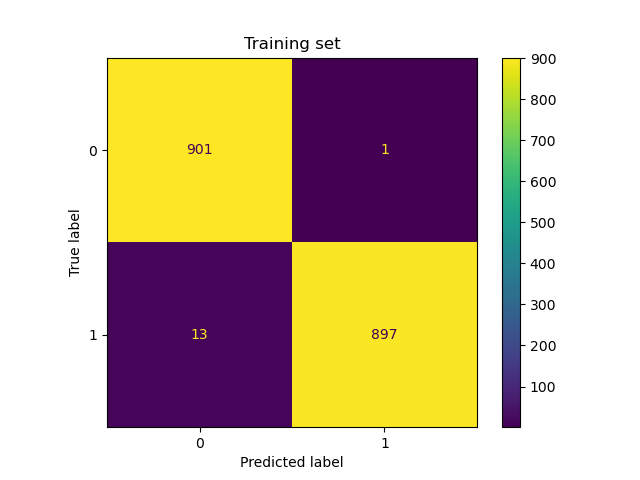

Acc: 0.986
F1:  0.992


<IPython.core.display.Javascript object>


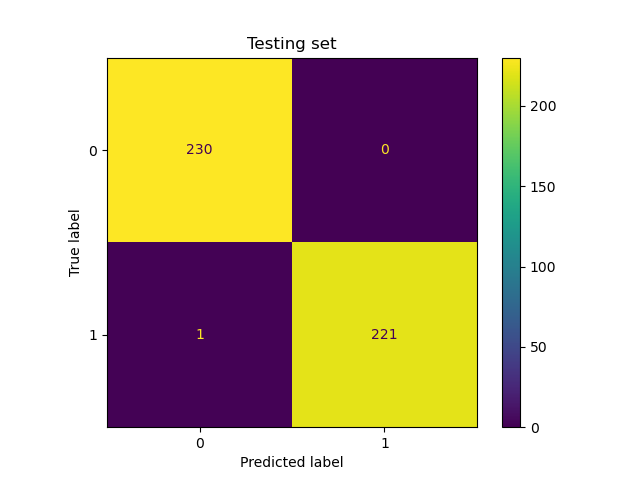

Acc: 0.995
F1:  0.998


<IPython.core.display.Javascript object>


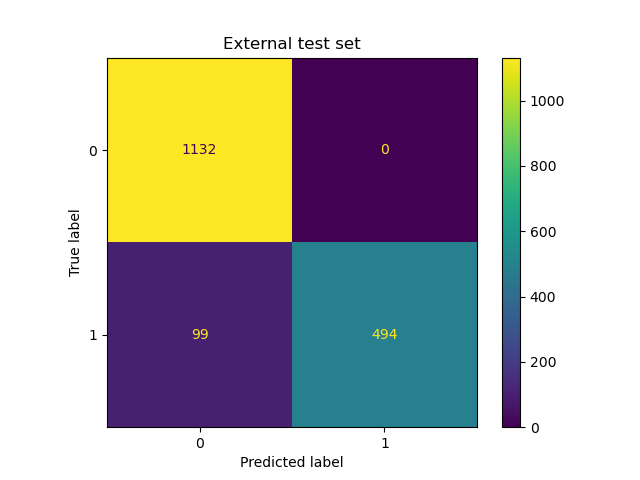

Acc: 0.833
F1:  0.909


In [18]:
y_train_pred = predict(x_lda, k_mean, k_cov, phi)

cm = confusion_matrix(y_train, y_train_pred)
#plt.figure()
cm_plot = ConfusionMatrixDisplay(cm)
cm_plot.plot()
plt.title('Training set')

tn, fp, fn, tp = cm.ravel()
f1 = tp/(tp + 0.5*(fp+fn))

plt.show()

print('Acc:', np.round(tp/(tp + fn), 3))
print('F1: ', np.round(f1, 3))

y_test_pred = predict(x_test_norm@W, k_mean, k_cov, phi)

cm = confusion_matrix(y_test, y_test_pred)
#plt.figure()
cm_plot = ConfusionMatrixDisplay(cm)
cm_plot.plot()
plt.title('Testing set')

tn, fp, fn, tp = cm.ravel()
f1 = tp/(tp + 0.5*(fp+fn))

plt.show()

print('Acc:', np.round(tp/(tp + fn), 3))
print('F1: ', np.round(f1, 3))


y_ext_test_pred = predict((test_features-mean)/std@W, k_mean, k_cov, phi)

cm = confusion_matrix(test_labels, y_ext_test_pred)
#plt.figure()
cm_plot = ConfusionMatrixDisplay(cm)
cm_plot.plot()
plt.title('External test set')

tn, fp, fn, tp = cm.ravel()
f1 = tp/(tp + 0.5*(fp+fn))

plt.show()

print('Acc:', np.round(tp/(tp + fn), 3))
print('F1: ', np.round(f1, 3))


# Clusterization

In [19]:
import numpy as np
from scipy.stats import multivariate_normal

class GaussianMixtureModel:
    def __init__(self, n_components, max_iterations=40000, tolerance=1e-10):
        self.n_components = n_components
        self.max_iterations = max_iterations
        self.tolerance = tolerance

        self.class_probability= np.ones(n_components) / n_components
        #self.class_probability = self.class_probability.reshape(-1, 1, 1) 
        self.means = None
        self.covariances = None
        self.eps = 1e-10

    def fit(self, x):
        n_samples, n_features = x.shape
        
        self.means = x[np.random.choice(n_samples, self.n_components, replace=False)]
        self._log_likelihood_prev = -float('inf')
        msg = 'Max. iter reached'
         # Initialize covariances based on the spread of the data
        data_covariance = np.cov(x, rowvar=False)
        self.covariances = np.tile(np.identity(n_features)*10, (self.n_components, 1, 1))

        for _ in range(self.max_iterations):
            # Expectation:
            responsibilities = self._calculate_responsibilities(x)

            # Maximization:
            self._update_parameters(x, responsibilities)
            
            ## Convergence check:
            if self.converged(x):
                msg = 'Converged'
                break
        print(msg)

        return self
    
    def converged(self, x):
        
        likelihood = self._log_likelihood(x)
        
        flag = np.abs(likelihood - self._log_likelihood_prev) < self.tolerance
        
        self._log_likelihood_prev = likelihood
        
        return flag
        
        
    def _calculate_responsibilities(self, x):
        likelihoods = np.zeros((self.n_components, x.shape[0]))
        
        for i in range(len(self.class_probability)):
            likelihoods[i, :] = multivariate_normal.pdf(x, 
                                                           mean=self.means[i, :], 
                                                           cov=self.covariances[i, :, :],
                                                       allow_singular=True)
        
        responsibilities = (self.class_probability[:, np.newaxis] * likelihoods)
        responsibilities[:, np.sum(responsibilities, axis=0)==0] = self.eps
        responsibilities /= np.sum(responsibilities, axis=0)

        return responsibilities

    def _update_parameters(self, x, responsibilities):
        # Update weights
        self.class_probability = np.mean(responsibilities, axis=1)

        # Update means
        self.means = (responsibilities @ x) / np.sum(responsibilities, axis=1)[:, np.newaxis]
        

        diff = x - self.means[:, np.newaxis]
        self.covariances =  np.sum(
                responsibilities[:, :, np.newaxis, np.newaxis]*\
                diff[:, :, :, np.newaxis] @ diff[:, :, :, np.newaxis].transpose((0, 1, 3, 2)),
                axis = 1)/ np.sum(responsibilities, axis=1)[:, np.newaxis, np.newaxis]
        self.covariances = (self.covariances + self.covariances.transpose((0, 2, 1)))/2
        
    def _log_likelihood(self, x):
        likelihoods = np.zeros((self.n_components, x.shape[0]))
        
        for i in range(len(self.class_probability)):
            likelihoods[i, :] = multivariate_normal.pdf(x, 
                                                           mean=self.means[i, :], 
                                                           cov=self.covariances[i, :, :],
                                                       allow_singular=True)
        likelihoods = self.class_probability[:, np.newaxis] * likelihoods
        likelihoods[likelihoods==0] = self.eps
        return np.sum(np.log(likelihoods))

    def predict(self, x):
        likelihoods = np.zeros((self.n_components, x.shape[0]))
        
        for i in range(len(self.class_probability)):
            likelihoods[i, :] = multivariate_normal.pdf(x, 
                                                           mean=self.means[i, :], 
                                                           cov=self.covariances[i, :, :],
                                                       allow_singular=True)
        return np.argmax(likelihoods, axis=0)

def vote_to_determine_label(predictions, true_labels):
    print(predictions.shape)
    updated_prediction = np.array(predictions)
    unassigned_clusters = np.unique(predictions).tolist()

    for label in np.unique(true_labels[::-1]):
        max_count = 0
        max_idx = 0
        
        for idx, cluster in enumerate(unassigned_clusters): 
            count = np.sum(true_labels[predictions==cluster] == label)
            if count > max_count:
                max_idx = idx
                max_count = count
                
        updated_prediction[predictions==unassigned_clusters[max_idx]] = label
        del unassigned_clusters[max_idx]
        
    return updated_prediction


In [20]:
# Define the path to the data folder
data_folder = "data"
train_data = "train"
data_folder_path = os.path.join(os.pardir, data_folder, train_data)

# Load data
folders_to_load = set(["female2", "female3", "male2", "male3", "male8"])
female_data, male_data = load_data(data_folder_path, folders_to_load)

In [21]:
num_to_sample = -1
female_sample = []
male_sample = []

i = 0
person_labels = []
for key in female_data:
    #female_sample += random.sample(female_data[key], num_to_sample)
    female_sample += female_data[key]
    #person_labels += [i]*num_to_sample
    person_labels += [i]*len(female_data[key])
    i+=1
    
for key in male_data:
    #male_sample += random.sample(male_data[key], num_to_sample)
    #person_labels += [i]*num_to_sample
    male_sample += male_data[key]
    person_labels += [i]*len(male_data[key])
    i+=1



training_data = female_sample + male_sample
gender_labels = [1]*len(female_sample) + [0]*len(male_sample)
gender_labels = np.array(gender_labels).reshape(-1, 1)

person_labels = np.array(person_labels).reshape(-1, 1)
training_data = normalize_data(downsample_data(training_data))
features = extract_features(training_data)


x_train = (features-np.mean(features, axis=0))/np.std(features, axis=0)

Converged
(3583,)


<IPython.core.display.Javascript object>


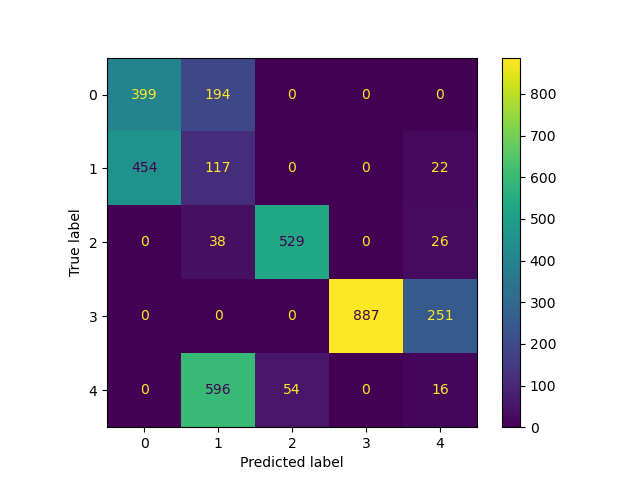

In [22]:
gmm = GaussianMixtureModel(n_components=5)
gmm.fit(x_train)

# Predict cluster assignments
predictions = gmm.predict(x_train)
predictions = vote_to_determine_label(predictions, person_labels.ravel())

cm = confusion_matrix(person_labels.ravel(), predictions)
#plt.figure()
cm_plot = ConfusionMatrixDisplay(cm)
cm_plot.plot()

Converged
(3583,)


<IPython.core.display.Javascript object>


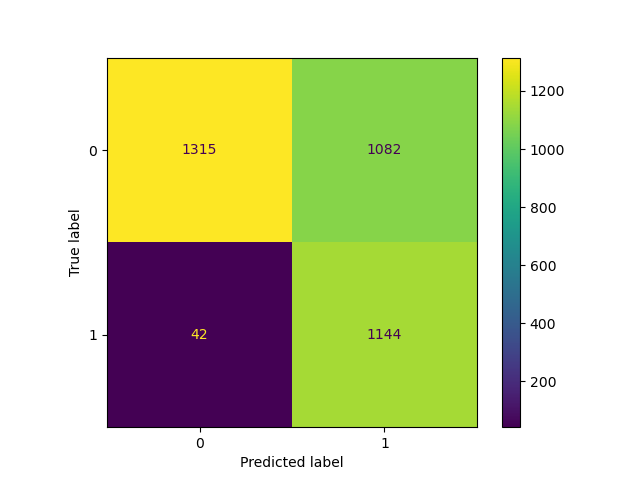

In [23]:
gmm = GaussianMixtureModel(n_components=2)
gmm.fit(x_train)

# Predict cluster assignments
predictions = gmm.predict(x_train)
predictions = vote_to_determine_label(predictions, gender_labels.ravel())

cm = confusion_matrix(gender_labels.ravel(), predictions)
#plt.figure()
cm_plot = ConfusionMatrixDisplay(cm)
cm_plot.plot()

Converged
(3583,)


<IPython.core.display.Javascript object>


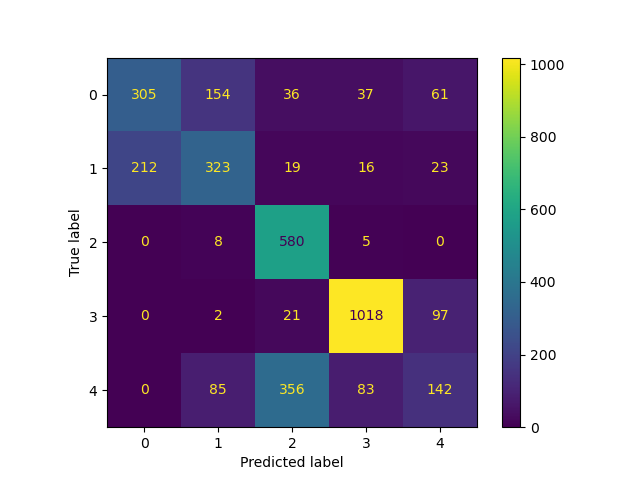

<IPython.core.display.Javascript object>


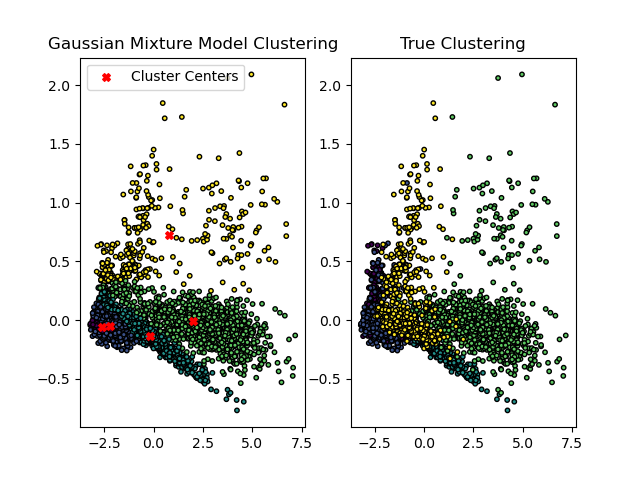

In [24]:
# Initialize and fit GMM

_, x_lda, S = lda(x_train, gender_labels.ravel(), n_components=2, mode='SbSw')

gmm = GaussianMixtureModel(n_components=5)
gmm.fit(x_lda)

# Predict cluster assignments
predictions = gmm.predict(x_lda)
predictions = vote_to_determine_label(predictions, person_labels.ravel())


cm = confusion_matrix(person_labels.ravel(), predictions)
#plt.figure()
cm_plot = ConfusionMatrixDisplay(cm)
cm_plot.plot()


fix, ax = plt.subplots(1, 2)
ax = ax.ravel()
ax[0].scatter(x_lda[:, 0], x_lda[:, 1], c=predictions, cmap='viridis', marker='o', edgecolors='k', s=10)
ax[0].scatter(gmm.means[:, 0], gmm.means[:, 1], c='red', marker='X', s=30, label='Cluster Centers')
ax[0].set_title('Gaussian Mixture Model Clustering')
ax[0].legend()

ax[1].set_title('True Clustering')
ax[1].scatter(x_lda[:, 0], x_lda[:, 1], c=person_labels.ravel(), cmap='viridis', marker='o', edgecolors='k', s=10)


plt.show()

Converged
(3583,)


<IPython.core.display.Javascript object>


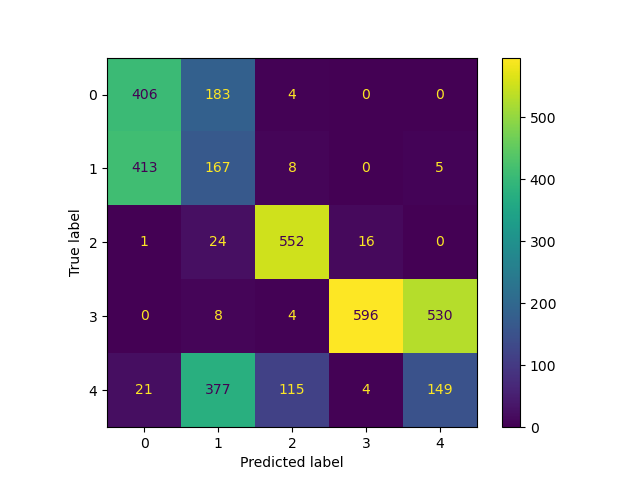

<IPython.core.display.Javascript object>


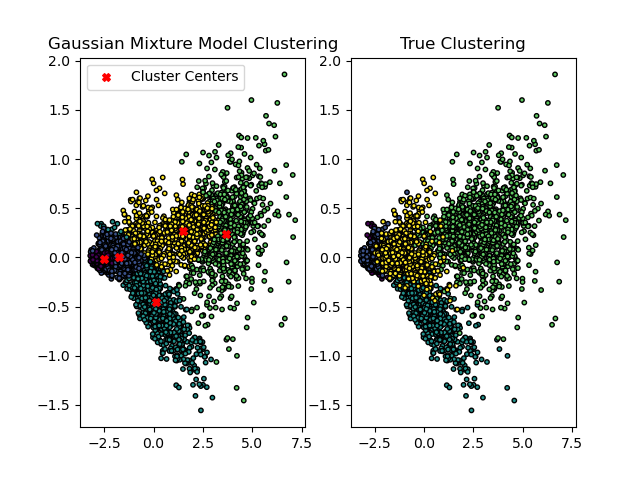

In [25]:
# Initialize and fit GMM

_, x_lda, S = lda(x_train, gender_labels.ravel(), n_components=2, mode='SbSm')

gmm = GaussianMixtureModel(n_components=5)
gmm.fit(x_lda)

# Predict cluster assignments
predictions = gmm.predict(x_lda)
predictions = vote_to_determine_label(predictions, person_labels.ravel())


cm = confusion_matrix(person_labels.ravel(), predictions)
#plt.figure()
cm_plot = ConfusionMatrixDisplay(cm)
cm_plot.plot()


fix, ax = plt.subplots(1, 2)
ax = ax.ravel()
ax[0].scatter(x_lda[:, 0], x_lda[:, 1], c=predictions, cmap='viridis', marker='o', edgecolors='k', s=10)
ax[0].scatter(gmm.means[:, 0], gmm.means[:, 1], c='red', marker='X', s=30, label='Cluster Centers')
ax[0].set_title('Gaussian Mixture Model Clustering')
ax[0].legend()

ax[1].set_title('True Clustering')
ax[1].scatter(x_lda[:, 0], x_lda[:, 1], c=person_labels.ravel(), cmap='viridis', marker='o', edgecolors='k', s=10)


plt.show()



Converged
(3583,)


C:\Users\milos\Anaconda3\envs\python38\lib\site-packages\sklearn\metrics\_plot\confusion_matrix.py:136: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()


<IPython.core.display.Javascript object>


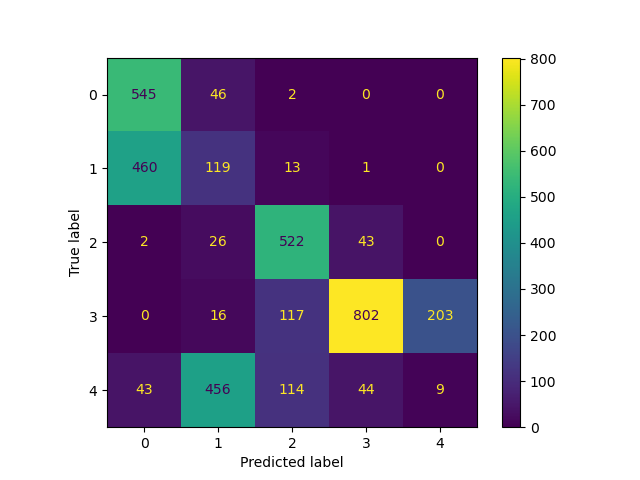

<IPython.core.display.Javascript object>


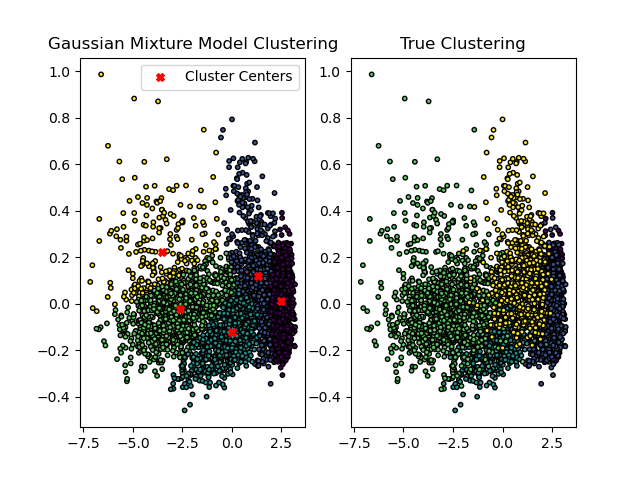

In [26]:
# Initialize and fit GMM

_, x_lda, S = lda(x_train, gender_labels.ravel(), n_components=2, mode='SwSm')

gmm = GaussianMixtureModel(n_components=5)
gmm.fit(x_lda)

# Predict cluster assignments
predictions = gmm.predict(x_lda)
predictions = vote_to_determine_label(predictions, person_labels.ravel())


cm = confusion_matrix(person_labels.ravel(), predictions)
#plt.figure()
cm_plot = ConfusionMatrixDisplay(cm)
cm_plot.plot()


fix, ax = plt.subplots(1, 2)
ax = ax.ravel()
ax[0].scatter(x_lda[:, 0], x_lda[:, 1], c=predictions, cmap='viridis', marker='o', edgecolors='k', s=10)
ax[0].scatter(gmm.means[:, 0], gmm.means[:, 1], c='red', marker='X', s=30, label='Cluster Centers')
ax[0].set_title('Gaussian Mixture Model Clustering')
ax[0].legend()

ax[1].set_title('True Clustering')
ax[1].scatter(x_lda[:, 0], x_lda[:, 1], c=person_labels.ravel(), cmap='viridis', marker='o', edgecolors='k', s=10)


plt.show()



Converged
(3583,)


<IPython.core.display.Javascript object>


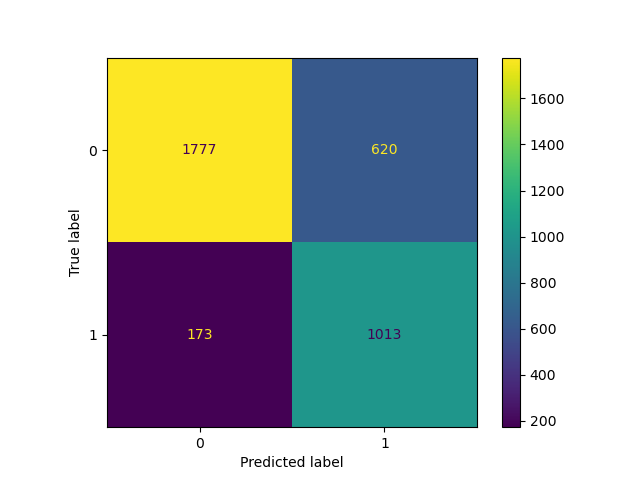

<IPython.core.display.Javascript object>


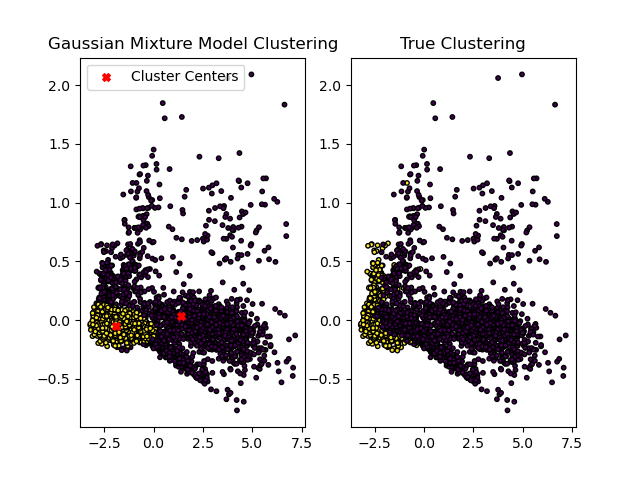

In [27]:
# Initialize and fit GMM

_, x_lda,S= lda(x_train, gender_labels.ravel(), n_components=2, mode='SbSw')

gmm = GaussianMixtureModel(n_components=2)
gmm.fit(x_lda)

# Predict cluster assignments
predictions = gmm.predict(x_lda)
predictions = vote_to_determine_label(predictions, gender_labels.ravel())



cm = confusion_matrix(gender_labels.ravel(), predictions)
cm_plot = ConfusionMatrixDisplay(cm)
cm_plot.plot()
plt.show()


fix, ax = plt.subplots(1, 2)
ax = ax.ravel()
ax[0].scatter(x_lda[:, 0], x_lda[:, 1], c=predictions, cmap='viridis', marker='o', edgecolors='k', s=10)
ax[0].scatter(gmm.means[:, 0], gmm.means[:, 1], c='red', marker='X', s=30, label='Cluster Centers')
ax[0].set_title('Gaussian Mixture Model Clustering')
ax[0].legend()

ax[1].set_title('True Clustering')
ax[1].scatter(x_lda[:, 0], x_lda[:, 1], c=gender_labels.ravel(), cmap='viridis', marker='o', edgecolors='k', s=10)


plt.show()

Converged
(3583,)


<IPython.core.display.Javascript object>


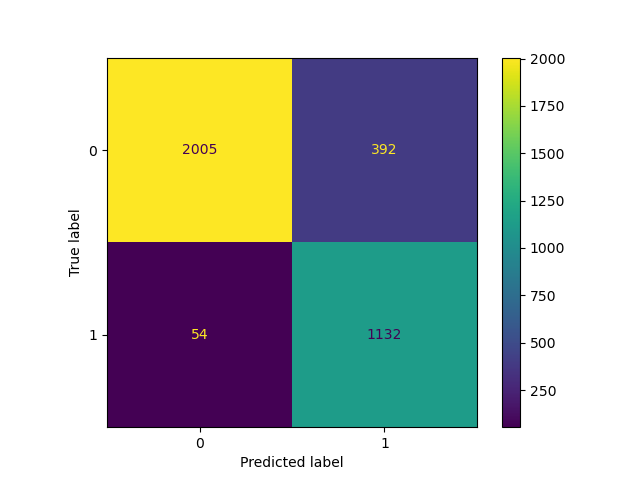

<IPython.core.display.Javascript object>


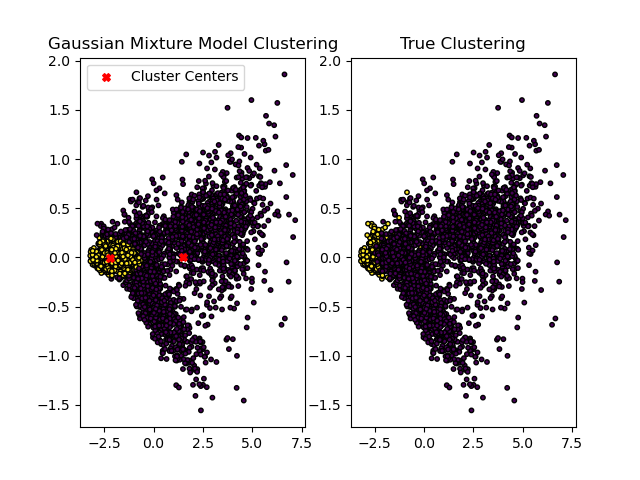

In [28]:
# Initialize and fit GMM

_, x_lda,S = lda(x_train, gender_labels.ravel(), n_components=2, mode='SbSm')

gmm = GaussianMixtureModel(n_components=2)
gmm.fit(x_lda)

# Predict cluster assignments
predictions = gmm.predict(x_lda)
predictions = vote_to_determine_label(predictions, gender_labels.ravel())



cm = confusion_matrix(gender_labels.ravel(), predictions)
cm_plot = ConfusionMatrixDisplay(cm)
cm_plot.plot()
plt.show()


fix, ax = plt.subplots(1, 2)
ax = ax.ravel()
ax[0].scatter(x_lda[:, 0], x_lda[:, 1], c=predictions, cmap='viridis', marker='o', edgecolors='k', s=10)
ax[0].scatter(gmm.means[:, 0], gmm.means[:, 1], c='red', marker='X', s=30, label='Cluster Centers')
ax[0].set_title('Gaussian Mixture Model Clustering')
ax[0].legend()

ax[1].set_title('True Clustering')
ax[1].scatter(x_lda[:, 0], x_lda[:, 1], c=gender_labels.ravel(), cmap='viridis', marker='o', edgecolors='k', s=10)


plt.show()

Converged
(3583,)


<IPython.core.display.Javascript object>


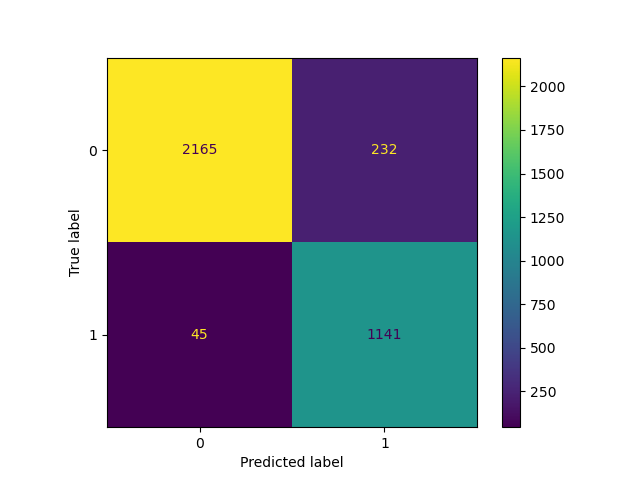

<IPython.core.display.Javascript object>


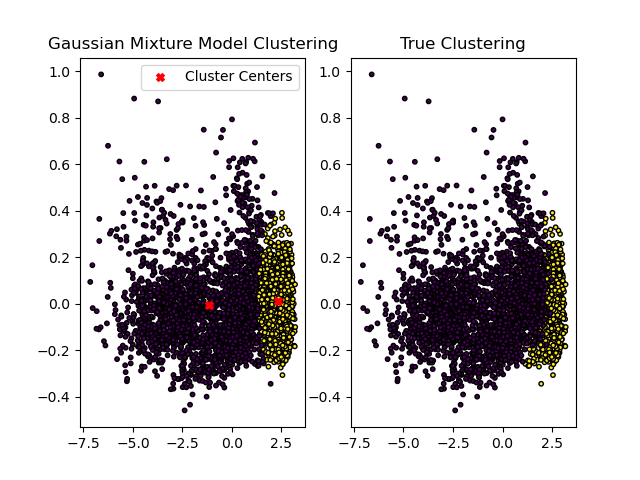

In [29]:
# Initialize and fit GMM

_, x_lda,S = lda(x_train, gender_labels.ravel(), n_components=2, mode='SwSm')

gmm = GaussianMixtureModel(n_components=2)
gmm.fit(x_lda)

# Predict cluster assignments
predictions = gmm.predict(x_lda)
predictions = vote_to_determine_label(predictions, gender_labels.ravel())



cm = confusion_matrix(gender_labels.ravel(), predictions)
cm_plot = ConfusionMatrixDisplay(cm)
cm_plot.plot()
plt.show()


fix, ax = plt.subplots(1, 2)
ax = ax.ravel()
ax[0].scatter(x_lda[:, 0], x_lda[:, 1], c=predictions, cmap='viridis', marker='o', edgecolors='k', s=10)
ax[0].scatter(gmm.means[:, 0], gmm.means[:, 1], c='red', marker='X', s=30, label='Cluster Centers')
ax[0].set_title('Gaussian Mixture Model Clustering')
ax[0].legend()

ax[1].set_title('True Clustering')
ax[1].scatter(x_lda[:, 0], x_lda[:, 1], c=gender_labels.ravel(), cmap='viridis', marker='o', edgecolors='k', s=10)


plt.show()

Converged
(3583,)


<IPython.core.display.Javascript object>


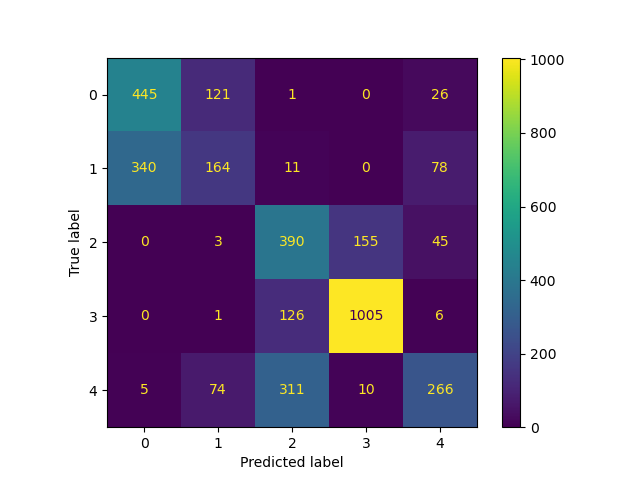

<IPython.core.display.Javascript object>


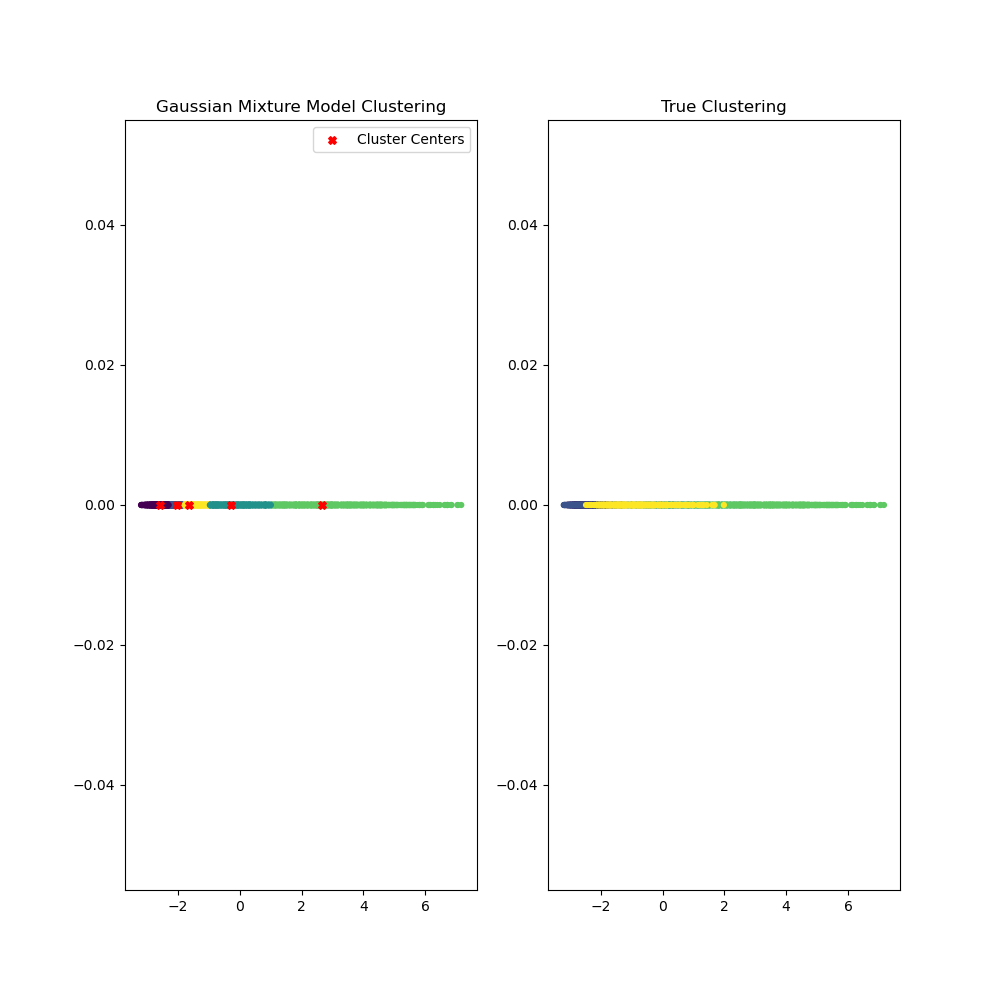

In [35]:
# Initialize and fit GMM

_, x_lda, S = lda(x_train, gender_labels.ravel(), n_components=1, mode='SbSm')

gmm = GaussianMixtureModel(n_components=5)
gmm.fit(x_lda)

# Predict cluster assignments
predictions = gmm.predict(x_lda)
predictions = vote_to_determine_label(predictions, person_labels.ravel())


cm = confusion_matrix(person_labels.ravel(), predictions)
#plt.figure()
cm_plot = ConfusionMatrixDisplay(cm)
cm_plot.plot()


fix, ax = plt.subplots(1, 2, figsize=(10, 10))
ax = ax.ravel()
ax[0].scatter(x_lda[:, 0], np.zeros_like(x_lda[:, 0]), c=predictions, cmap='viridis', marker='o', edgecolors='none', s=20)
ax[0].scatter(gmm.means[:, 0], np.zeros_like(gmm.means[:, 0]), c='red', marker='X', s=30, label='Cluster Centers')
ax[0].set_title('Gaussian Mixture Model Clustering')
ax[0].legend()

ax[1].set_title('True Clustering')
ax[1].scatter(x_lda[:, 0], np.zeros_like(x_lda[:, 0]), c=person_labels.ravel(), cmap='viridis', marker='o', 
              edgecolors='none', s=20)


plt.show()



Converged
(3583,)


<IPython.core.display.Javascript object>


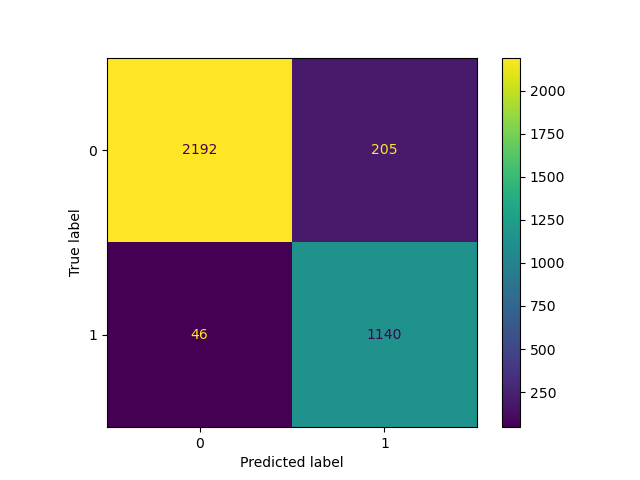

<IPython.core.display.Javascript object>


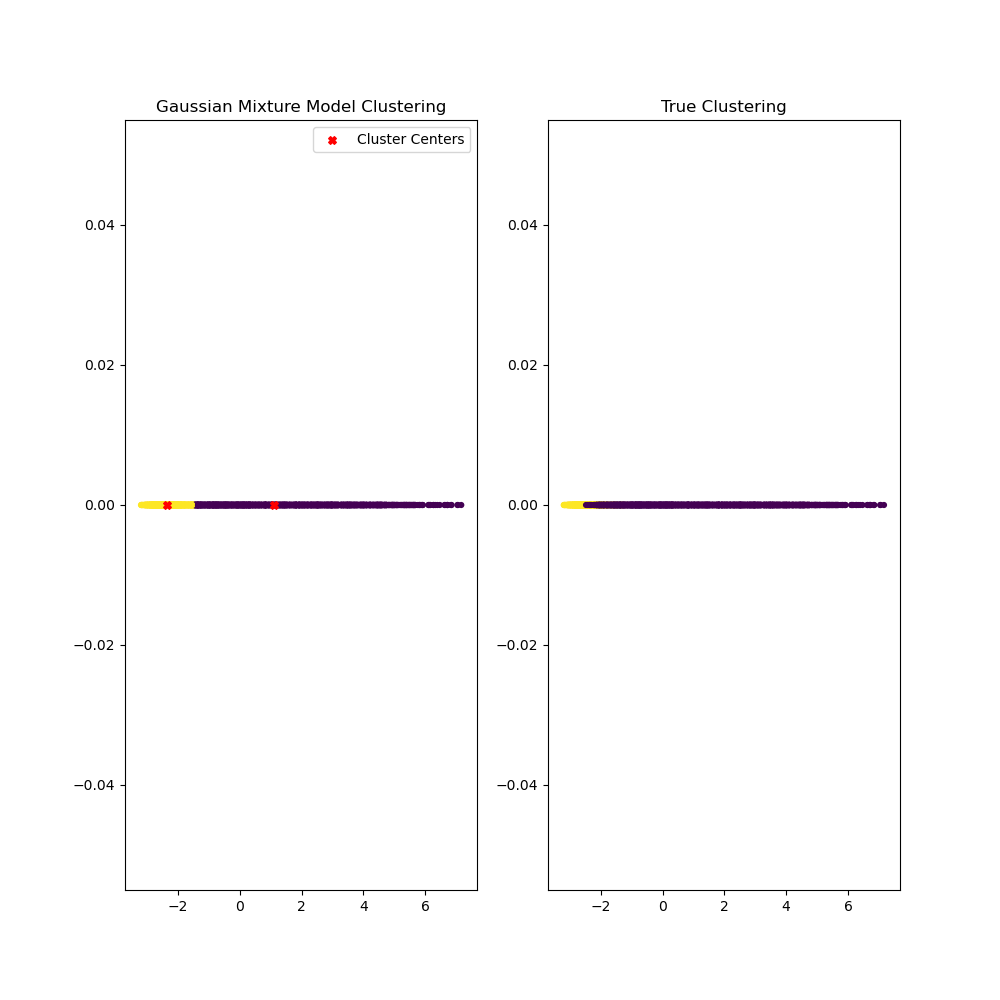

In [36]:
# Initialize and fit GMM

_, x_lda,S= lda(x_train, gender_labels.ravel(), n_components=1, mode='SbSw')

gmm = GaussianMixtureModel(n_components=2)
gmm.fit(x_lda)

# Predict cluster assignments
predictions = gmm.predict(x_lda)
predictions = vote_to_determine_label(predictions, gender_labels.ravel())



cm = confusion_matrix(gender_labels.ravel(), predictions)
cm_plot = ConfusionMatrixDisplay(cm)
cm_plot.plot()
plt.show()


fix, ax = plt.subplots(1, 2, figsize=(10, 10))
ax = ax.ravel()
ax[0].scatter(x_lda[:, 0], np.zeros_like(x_lda[:, 0]), c=predictions, cmap='viridis', marker='o', edgecolors='none', s=20)
ax[0].scatter(gmm.means[:, 0], np.zeros_like(gmm.means[:, 0]), c='red', marker='X', s=30, label='Cluster Centers')
ax[0].set_title('Gaussian Mixture Model Clustering')
ax[0].legend()

ax[1].set_title('True Clustering')
ax[1].scatter(x_lda[:, 0], np.zeros_like(x_lda[:, 0]), c=gender_labels.ravel(), 
              cmap='viridis', marker='o', edgecolors='none', s=20)


plt.show()